In [2]:
from generators.brownian_motion_generator import BrownianMotionDataset
from generators.poisson_process_generator import PoissonProcessDataset
from models.vanilla_transformer import TransformerModel
from probes.linear_probe import LinearProbe
import matplotlib.pyplot as plt
import torch
import pandas as pd
from generators.nn_generator import NNGenerator
from tqdm import tqdm

In [3]:
checkpoint_path = "/home/wojciech/private/magisterka/TFTS/training/transformer_stochastic_processes/9h265ze8/checkpoints/transformer-epoch=142-val_loss=0.16.ckpt"
# Load the trained model
model = TransformerModel.load_from_checkpoint(checkpoint_path)
dataloader = NNGenerator(batch_size=1, series_length=40, subseries_length=1, stride=1, store_params=True).get_dataloader()
model.eval()

preds_list = []
labels_list = []
activations = []

total_loss = 0.0
with torch.no_grad():
    for i in range(1):
        for x, y in tqdm(dataloader):
            x = x.float().to('cuda')
            # y = dataloader.dataset.get_parameters(y)
            embeddings = model(x)
            tmp = {k: v.clone() for k, v in model.get_activations().items()}
            preds_list.append(embeddings)
            labels_list.append(y)
            activations.append(tmp)

/home/wojciech/anaconda3/envs/TFTS/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 1000/1000 [00:15<00:00, 66.22it/s]


In [4]:
# Flatten the results and prepare data for DataFrame
preds_array = [pred.squeeze(0).tolist() for pred in preds_list]
mean_std_array = [label.squeeze(0).tolist() for label in labels_list]
embedding_columns = {f"embedding_{i}": [embedding[i] for embedding in preds_array] for i in range(128)}

df = pd.DataFrame({
    **embedding_columns,
    "label": mean_std_array,
    # "Std": [mean_std[1] for mean_std in mean_std_array]
})

In [5]:
df["label"].value_counts()

label
0      4
171    4
158    4
159    4
160    4
      ..
88     4
89     4
90     4
91     4
249    4
Name: count, Length: 250, dtype: int64

In [6]:
df["label"] = (df["label"] % 250) < 125

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Assuming the DataFrame is already created as df
# Filter embeddings and labels
X = df[[col for col in df.columns if col.startswith("embedding_")]]  # Embedding columns
y = df["label"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = logreg.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.45      0.38      0.41       104
        True       0.42      0.49      0.45        96

    accuracy                           0.43       200
   macro avg       0.44      0.44      0.43       200
weighted avg       0.44      0.43      0.43       200

Accuracy Score: 0.435


In [9]:
pd.Series(y_test).value_counts()

label
False    104
True      96
Name: count, dtype: int64

/home/wojciech/anaconda3/envs/TFTS/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


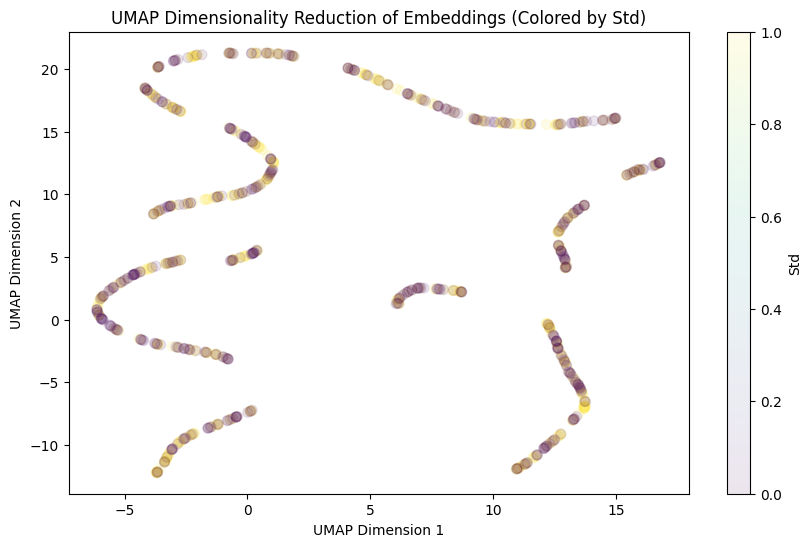

In [13]:
# Using UMAP with umap-learn package (correct import)
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Apply UMAP to reduce embeddings to 2 dimensions
embedding_matrix = df[[f"embedding_{i}" for i in range(128)]].values
reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = reducer.fit_transform(embedding_matrix)

# Create a scatter plot with color representing the 'Std' value
plt.figure(figsize=(10, 6))
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=(df["label"]), s=50, alpha=0.1)
plt.colorbar(scatter, label='Std')
plt.title('UMAP Dimensionality Reduction of Embeddings (Colored by Std)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


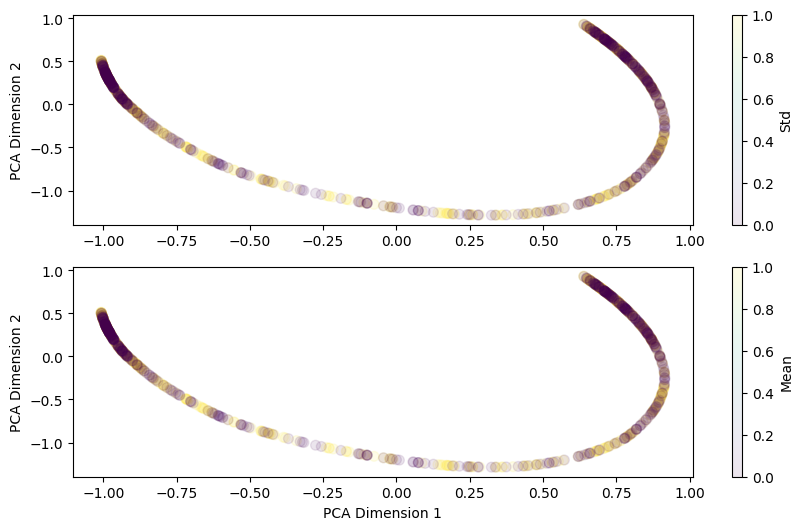

In [12]:
from sklearn.decomposition import PCA

# Apply PCA to reduce embeddings to 2 dimensions
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embedding_matrix)

# Create a scatter plot with color representing the 'Std' value
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))
scatter = ax1.scatter(pca_results[:, 0], pca_results[:, 1], c=(df["label"]), cmap='viridis', s=50, alpha=0.1)
scatter2 = ax2.scatter(pca_results[:, 0], pca_results[:, 1], c=(df["label"]), cmap='viridis', s=50, alpha=0.1)
plt.colorbar(scatter, label='Std')
plt.colorbar(scatter2, label='Mean')

plt.xlabel('PCA Dimension 1')
ax1.set_ylabel('PCA Dimension 2')
ax2.set_ylabel('PCA Dimension 2')
plt.show()


In [7]:
samples = torch.stack([torch.concat([x.flatten() for x in activations[i].values()]) for i in range(len(activations))])

In [8]:
samples

tensor([[ -2.4934, -11.3963,  -8.2560,  ...,   0.5782,   0.3453,  -1.0909],
        [ -2.4900, -11.3770,  -8.2422,  ...,   0.5782,   0.3453,  -1.0910],
        [ -2.4915, -11.3856,  -8.2484,  ...,   0.5782,   0.3453,  -1.0910],
        ...,
        [ -0.3165,   1.0478,   0.5927,  ...,   0.6663,   0.3444,  -1.1513],
        [ -0.0208,   2.7383,   1.7947,  ...,   0.6247,   0.3737,  -1.1254],
        [  0.0962,   3.4071,   2.2703,  ...,   0.6066,   0.3834,  -1.1174]],
       device='cuda:0')

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Assuming the DataFrame is already created as df
# Filter embeddings and labels
X = samples.cpu().numpy() # Embedding columns
y = df["label"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = logreg.predict(X_train)
print("Classification Report:")
print(classification_report(y_train, y_pred))

print("Accuracy Score:", accuracy_score(y_train, y_pred))

KeyboardInterrupt: 

In [107]:
df["label"]

0       True
1       True
2       True
3       True
4       True
       ...  
995    False
996    False
997    False
998    False
999    False
Name: label, Length: 1000, dtype: bool

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, accuracy_score, r2_score


def get_loss(layer, weight):
    def get_param(label):
        for param in dataloader.dataset.get_parameters(label).network[layer].parameters():
            return param.view(-1).detach().cpu().numpy()[weight]
        
    df["param_0"] = df["label"].apply(get_param)
    X = samples.cpu().numpy() # Embedding columns
    y = df["param_0"]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train logistic regression model
    lr = Lasso(random_state=42, alpha=1)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    
    return r2_score(y_train, y_pred), r2_score(y_test, y_pred_test)

weights_num = [2*4, 4*4, 4*1]
results = []
for layer in range(3):
    curr = []
    for weight in range(weights_num[layer]):
        curr.append(get_loss(layer*2, weight))
    results.append(curr)

(array([2., 0., 1., 5., 0., 5., 3., 4., 6., 2.]),
 array([-0.03039145, -0.02584531, -0.02129916, -0.01675301, -0.01220686,
        -0.00766072, -0.00311457,  0.00143158,  0.00597773,  0.01052387,
         0.01507002]),
 <BarContainer object of 10 artists>)

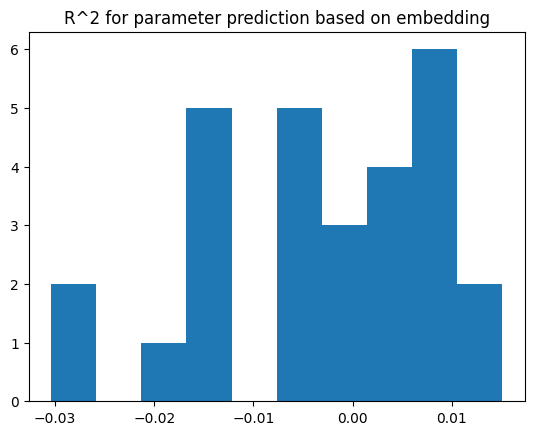

In [55]:
plt.title("R^2 for parameter prediction based on embedding")
plt.hist([x[1] for a in results for x in a])

In [40]:
for param in dataloader.dataset.get_parameters(1).network[2].parameters():
    print(param)
    print(param.view(-1))

Parameter containing:
tensor([[-0.2970,  3.4230, -0.5789, -0.2642],
        [ 4.3886,  8.4225,  6.3639,  5.3497],
        [-8.0722, -1.7810,  0.0456, -7.0534],
        [ 5.1394, -2.4885, -0.2833,  0.4525]], requires_grad=True)
tensor([-0.2970,  3.4230, -0.5789, -0.2642,  4.3886,  8.4225,  6.3639,  5.3497,
        -8.0722, -1.7810,  0.0456, -7.0534,  5.1394, -2.4885, -0.2833,  0.4525],
       grad_fn=<ViewBackward0>)
Parameter containing:
tensor([ 0.5491,  0.8696, -0.3498, -0.3267], requires_grad=True)
tensor([ 0.5491,  0.8696, -0.3498, -0.3267], grad_fn=<ViewBackward0>)


/home/wojciech/anaconda3/envs/TFTS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+02, tolerance: 2.365e+00
  model = cd_fast.enet_coordinate_descent(


(0.08495926856994629, -0.05275166034698486)

In [20]:
(lr.coef_ == 0).mean()

0.9898726851851852